# Battle of the Neighborhoods - Week 2
### IBM Coursera Data Science Specialization - Applied Capstone Project

## Table of Contents
- [A.&emsp;Introduction](#introduction)
- [B.&emsp;The Data](#thedata)
- [C.&emsp;Methodology](#methodology)
    - [1.&emsp;Analytic approach](#analyticalapproach)
    - [2.&emsp;Analysis](#analysis)
- [D.&emsp;Results](#results)
- [E.&emsp;Discussion](#discussion)
- [F.&emsp;Conclusion](#conclusion)
- [G.&emsp;Acknowledgment](#acknowledgment)

<a id="introduction"></a>
## A. Introduction

### 1. Background
Mr. John Smith is a senior executive at ACME Widgets Inc in Southern California, USA. ACME has experienced severe downturn in its business due to the COVID-19 pandemic and is planning to close its facilities in the state. The company has offered Mr. Smith the choice of being laid off or relocating to it's offices in the city of Austin in the state of Texas. Mr. Smith has opted to relocate to Austin.

Austin is a vibrant and dynamic city and is the capital of Texas. It has a population of over 2 million. It is home to the University of Texas and is known for its parks, and lakes, and outdoor activities. The city is well known for its live music scene, featured in the long running PBS music series *Austin City Limits*. Many of the well known technology companies have major facilities in the city. See Austin's [Wikipedia entry](https://en.wikipedia.org/wiki/Austin,_Texas) for more information.


### 2. The problem
Mr. Smith has visited Austin a couple of times for business. He is not familiar with the neighborhoods in the city. Ideally, he would like to rent or buy a home in a neighborhood similar to the one he currently resides in - [Westpark](https://www.niche.com/places-to-live/n/westpark-irvine-ca/), in the city of Irvine in California. He could consult with real estate agents (realtors) in Austin for their opinions on neighborhoods and make a choice based on the feedback. However, the opinions are likely to be biased or highly subjective. It is also unlikely that any of the Austin realtors know about the Westpark neigborhood.  Therefore, Mr. Smith would like a recommendation on Austin neighborhoods based on data analysis, which he can compare with the recommendations of realtors in the city.

<a id="thedata"></a>
## B. The Data 
To provide Mr. Smith with an objective, analytical recommendation, geospatial data from Foursquare and other sources will be used in the analysis.

The following datasets will be used:

| Data Description | Data Source  
| :--- | :----
| 1. Neighborhoods in Austin | The city of Austin has a comprehensive data portal. One of the datasets available is a list of neighborhoods in GEOJSON format. The URL for the dataset is https://data.austintexas.gov/Building-and-Development/Neighborhoods/a7ap-j2yt. This data will be used instead of the Wikipedia page for Austin neighborhoods at https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods
| 2. Geographical coordinate data for neighborhoods in Austin | Nominatim
| 3. Geographical coordinate data for Westpark | Nominatim
| 4. Top 100 venues for Austin neighborhoods | Foursquare
| 5. Top 100 venues for Westpark | Foursquare

**Data preparation**

1. Create a data frame of neighborhoods in Austin with latitude and longitude
2. Append data for Westpark to the dataframe
3. Get top 100 venues for the neighborhoods

<a id="methodology"></a>
## C. METHODOLOGY

<a id="analyticalapproach"></a>
### 1. Analytical Approach 
The objective is to classify Austin neighborhoods into groups or clusters based on the features of each neighborhood. This will identify the types of neighborhoods in Austin. Since we are trying to identify groups that have not been labelled, the K-means clustering algorithm will be used. By including Westpark as a "Austin neighborhood", we will be able to see which cluster it is included in for a given optimal K clusters. The optimal K will be determined using the elbow method.

The list of Austin neighborhoods with the same cluster label as Westpark will be recommended to Mr. Smith as the most likely candidates for his relocation plans.


**Data Analysis Steps**
- Fit the data to K-means for 1 to 15 clusters
- Identify optimal number of clusters using elbow method
- Fit the data to K-means for optimal number of clusters determined by elbow method in step 2
- Visualize clusters on 2D chart
- Visualize location of clusters on map of Austin
- List the neighborhoods in Austin in the same cluster as Westpark, ranked in ascending order of distance to the cluster centroid

<a id="analysis"></a>
### 2. Analysis
#### a. Import required libraries

In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import seaborn as sns

import json                                             # library to handle JSON files
from pandas.io.json import json_normalize               # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt                         # plotting library

!pip install geopy
from geopy.geocoders import Nominatim                   # convert an address into latitude and longitude values

!pip install folium
import folium                                           # map rendering library

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
print("Libraries imported")

     |████████████████████████████████| 112 kB 6.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 94 kB 3.0 MB/s eta 0:00:011
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 269 kB 6.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Libraries imported


#### b. Define functions

In [2]:
# DEFINE FUNCTIONS AND DATAFRAMES

# GET LAT AND LONG FOR AN ADDRESS
def getlatlong(address):
    geolocator = Nominatim(user_agent="irvaus_explorer")
    location = geolocator.geocode(address)
    if location == None:
        return (0, 0)
    latitude = location.latitude
    longitude = location.longitude
    return (latitude, longitude)

# GET NEARBY VENUES FROM FOURSQUARE
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood latitude', 
                  'neighborhood longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [3]:
# DEFINE NEIGHBORHOOD MOVING FROM
from_hood = 'Westpark, Irvine CA'

#### c. Acquire neighborhood and venue data from Austin City Portal and FourSquare and save it to local csv files
For subsequent executions of this notebook, data can be re-read from csv files. Cells in section C.2.c. can be skipped.

In [4]:
!wget -q -O 'aus_hood_data.json' https://data.austintexas.gov/resource/a7ap-j2yt.geojson
print("Austin Neighborhood data downloaded and saved")

Austin Neighborhood data downloaded and saved


In [8]:
# CREATE DATA FRAME FOR NEIGHBORHOODS AND GEO COORDINATES

df_nhfrom = pd.DataFrame(columns = ['neighborhood', 'latitude', 'longitude'])  # DATAFRAME FOR CURRENT NEIGHBORHOOD

#                                      CREATE ROW FOR PRESENT NEIGHBORDHOOD IN CALIFORNIA
neighborhood = from_hood
geoaddress = from_hood
latitude, longitude = getlatlong(geoaddress)
row = [neighborhood, latitude, longitude]
df_nhfrom.loc[0] = row


df_nhto = pd.DataFrame(columns = ['neighborhood', 'latitude', 'longitude'])
latitude = longitude = 0

with open('aus_hood_data.json') as json_data:
    austin_hoods = json.load(json_data)

ncount = len(austin_hoods['features'])
no_latlong = 0
for i in range(ncount):
    hood = austin_hoods['features'][i]['properties']['neighname']
    geoaddress = hood + ', Austin TX'  
    latitude, longitude = getlatlong(geoaddress)
    if latitude == 0 and longitude == 0:
        no_latlong = no_latlong + 1
        continue
    row = [hood, latitude, longitude]
    df_nhto.loc[i] = row

print("Neighborhoods with no geo coordinates", no_latlong)   
df_geo = pd.concat([df_nhfrom, df_nhto], ignore_index=True)
df_geo.head()

Neighborhoods with no geo coordinates 14


,neighborhood,latitude,longitude
0,"Westpark, Irvine CA",33.691352,-117.808844
1,ANDERSON MILL,30.455835,-97.807096
2,WINDSOR PARK,30.313549,-97.691095
3,DAWSON,30.232926,-97.761418
4,WEST UNIVERSITY,30.281666,-97.738766


In [9]:
df_geo.shape

(90, 3)

In [1]:
# The code was removed by Watson Studio for sharing.

In [11]:
# GET NEARBY VENUES FOR NEIGHBORHOODS FROM FOURSQUARE AND SAVE THEM TO LOCAL FILE
df_venues = getNearbyVenues(names=df_geo['neighborhood'],
                                   latitudes=df_geo['latitude'],
                                   longitudes=df_geo['longitude']
                                  )

Westpark, Irvine CA
ANDERSON MILL
WINDSOR PARK
DAWSON
WEST UNIVERSITY
MLK
SOUTH RIVER CITY
MLK-183
OLD WEST AUSTIN
BOULDIN CREEK
WALNUT CREEK--PIONEER HILL
SOUTHEAST
UNIVERSITY HILLS
WINDSOR ROAD
JESTER
CIRCLE C SOUTH
WESTGATE
GALINDO
BRODIE LANE
HYDE PARK
MCKINNEY
WESTOVER HILLS
GRACY WOODS
PLEASANT VALLEY
SOUTH LAMAR
PECAN SPRINGS-SPRINGDALE
FOUR POINTS
POND SPRINGS
ST. EDWARDS
UT
HIGHLAND
DOWNTOWN
HANCOCK
TECH RIDGE
SAMSUNG--PIONEER CROSSING
WEST AUSTIN NG
BLUFF SPRINGS
MONTOPOLIS
CHERRY CREEK
BARTON HILLS
GATEWAY
WOOTEN
HOLLY
GARRISON PARK
GEORGIAN ACRES
EAST CESAR CHAVEZ
NORTH LOOP
MCNEIL
DAVENPORT LAKE AUSTIN
ZILKER
LBJ
WEST CONGRESS
BULL CREEK
HERITAGE HILLS
OLD ENFIELD
CHESTNUT
ROSEDALE
NORTH BURNET
BERGSTROM
SOUTH BRODIE
DECKER LAKE
GOVALLE
NORTH SHOAL CREEK
RIVERSIDE
WEST OAK HILL
CORONADO HILLS
ONION CREEK
HIGHLAND PARK
ROSEWOOD
PARKER LANE
ALLANDALE
EAST CONGRESS
CRESTVIEW
CENTRAL EAST AUSTIN
HARRIS BRANCH
TRIANGLE STATE
ST. JOHNS
JOHNSTON TERRACE
NORTHWEST HILLS
JOLLYVILLE

In [12]:
print("Venue data rows, cols:", df_venues.shape)
df_venues.tail()

Venue data rows, cols: (1285, 7)


,neighborhood,neighborhood latitude,neighborhood longitude,venue,venue latitude,venue longitude,venue category
1280,WINDSOR HILLS,30.362072,-97.679214,CORT Furniture Rental & Clearance Center,30.363104,-97.683857,Furniture / Home Store
1281,ROGERS HILL,30.278922,-97.638873,Leal's Tire Service Inc.,30.276237,-97.636300,Auto Garage
1282,ROGERS HILL,30.278922,-97.638873,Indras Awarehouse,30.279605,-97.643773,Yoga Studio
1283,EAST OAK HILL,30.202662,-97.655919,Family Viewing Area (Airport),30.200686,-97.655203,Other Great Outdoors
1284,EAST OAK HILL,30.202662,-97.655919,TXDOT Flight Services,30.202218,-97.654121,Airport Service


In [13]:
# SAVE DATAFRAMES TO LOCAL FILES 
df_geo.to_csv('df_geo_aus.csv') 
df_geo.drop(df_geo.index, inplace=True)

df_venues.to_csv('df_venues_aus.csv') 
df_venues.drop(df_venues.index, inplace=True)

#### d. Read back previously saved data on neighborhoods and venues

In [14]:
# READ BACK DATA FROM LOCAL FILES
df_geo = pd.read_csv('df_geo_aus.csv', index_col=0)
df_venues = pd.read_csv('df_venues_aus.csv', index_col=0)

# DROP NEIGHBORHOODS FOR WHICH NO VENUES WERE FOUND
droprows = []
for row in df_geo.index: 
    checkhood = df_geo['neighborhood'][row]
    if checkhood not in df_venues['neighborhood'].values:
        print(checkhood, "dropped, no venues")
        droprows.append(row)

df_geo.drop(index=droprows, axis=0, inplace=True)  
df_geo.reset_index(drop=True)

CHERRY CREEK dropped, no venues
DECKER LAKE dropped, no venues
ALLANDALE dropped, no venues
NORTHWEST HILLS dropped, no venues


,neighborhood,latitude,longitude
0,"Westpark, Irvine CA",33.691352,-117.808844
1,ANDERSON MILL,30.455834,-97.807096
2,WINDSOR PARK,30.313549,-97.691095
3,DAWSON,30.232926,-97.761418
4,WEST UNIVERSITY,30.281666,-97.738766
...,...,...,...
81,SWEETBRIAR,30.201563,-97.781185
82,SPICEWOOD,30.432946,-97.770378
83,WINDSOR HILLS,30.362072,-97.679214
84,ROGERS HILL,30.278922,-97.638873


#### e. Run K-means and determine optimal number of clusters
Run K-means for number of clusters from 1 to 15 to determine the optimal number of clusters using the elbow method. The KElbowVisualizer in the yellowbrick library will be used to the obtain the elbow value.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


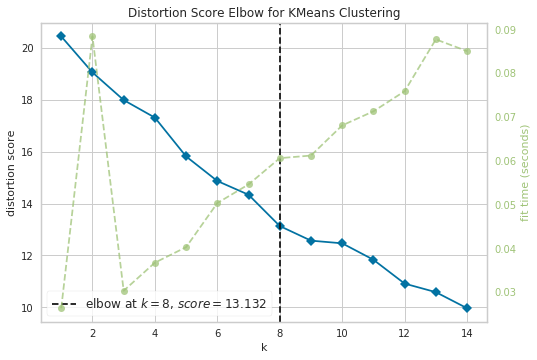

In [15]:
# APPLY ONE HOT ENCODING

df_1hot = pd.get_dummies(df_venues[['venue category']], prefix="", prefix_sep="")
df_1hot['neighborhood'] = df_venues['neighborhood']                    # add neighborhood column back to dataframe
col_order = [df_1hot.columns[-1]] + list(df_1hot.columns[:-1])         # move neighborhood column to the first column
df_1hot = df_1hot[col_order]

df_grouped = df_1hot.groupby('neighborhood').mean().reset_index()      # calculate mean of frequency of occurrence of
                                                                       # venue types grouped by neighborhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['neighborhood']                                            # create columns according to number of top venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

df_venue_sort = pd.DataFrame(columns=columns)                        # create a new dataframe
df_venue_sort['neighborhood'] = df_grouped['neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    df_venue_sort.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

df_clustering = df_grouped.drop('neighborhood', 1)

ybviz = KElbowVisualizer(KMeans(), k=(1,15))
ybviz = ybviz.fit(df_clustering)
ybviz.show()

In [16]:
kclusters = ybviz.elbow_value_
print("The elbow is at", kclusters, "indicating optimal number of clusters for dataset is", kclusters)

The elbow is at 8 indicating optimal number of clusters for dataset is 8


#### f. Run K-means for optimal number of clusters

In [17]:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)     # run k-means clustering

df_venue_sort.insert(0, 'cluster labels', kmeans.labels_)                    # add clustering labels

df_labeled = df_geo
df_labeled = df_labeled.join(df_venue_sort.set_index('neighborhood'), on='neighborhood')
df_labeled.head()

,neighborhood,latitude,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Westpark, Irvine CA",33.691352,-117.808844,6,Playground,Park,Pool,Other Repair Shop,Yoga Studio,Electronics Store,Food Truck,Food Court,Food & Drink Shop,Flower Shop
1,ANDERSON MILL,30.455834,-97.807096,6,Park,Auto Workshop,Pool,Yoga Studio,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Field
2,WINDSOR PARK,30.313549,-97.691095,0,Pizza Place,Cosmetics Shop,Restaurant,Taco Place,Food Truck,Discount Store,Gym / Fitness Center,Pharmacy,Veterinarian,Health & Beauty Service
3,DAWSON,30.232926,-97.761418,0,Smoke Shop,Convenience Store,Bar,BBQ Joint,Coffee Shop,Athletics & Sports,Garden Center,Taco Place,Hawaiian Restaurant,Cosmetics Shop
4,WEST UNIVERSITY,30.281666,-97.738766,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Bubble Tea Shop,Hotel,Art Museum,Sushi Restaurant,Public Art,Pool,Movie Theater


#### h. Add squared distance from centroid data for each neighborhood to the dataframe

In [18]:
node_dist = kmeans.transform(df_clustering)**2
df_dist = pd.DataFrame(node_dist.sum(axis=1).round(2), columns=['sqdist'])
df_labeled['sqdist'] = df_dist['sqdist']

In [19]:
df_labeled.head()

,neighborhood,latitude,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sqdist
0,"Westpark, Irvine CA",33.691352,-117.808844,6,Playground,Park,Pool,Other Repair Shop,Yoga Studio,Electronics Store,Food Truck,Food Court,Food & Drink Shop,Flower Shop,7.07
1,ANDERSON MILL,30.455834,-97.807096,6,Park,Auto Workshop,Pool,Yoga Studio,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Field,8.40
2,WINDSOR PARK,30.313549,-97.691095,0,Pizza Place,Cosmetics Shop,Restaurant,Taco Place,Food Truck,Discount Store,Gym / Fitness Center,Pharmacy,Veterinarian,Health & Beauty Service,10.65
3,DAWSON,30.232926,-97.761418,0,Smoke Shop,Convenience Store,Bar,BBQ Joint,Coffee Shop,Athletics & Sports,Garden Center,Taco Place,Hawaiian Restaurant,Cosmetics Shop,6.59
4,WEST UNIVERSITY,30.281666,-97.738766,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Bubble Tea Shop,Hotel,Art Museum,Sushi Restaurant,Public Art,Pool,Movie Theater,5.18


#### i. Plot clusters on a 2D chart using Principle Component Analysis
The neighbordhood data has multiple features or dimensions. We will reduce it to two dimensions to visualize clusters on a 2D chart.

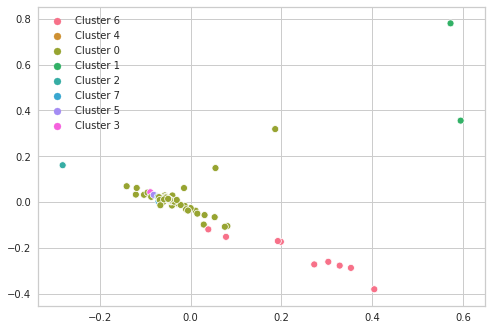

In [20]:
pca = PCA(n_components=2)
pca.fit(df_clustering)

df_pca = pd.DataFrame(pca.transform(df_clustering), columns=['pca1', 'pca2'], index=df_clustering.index)
df_pca.insert(0, 'cluster labels', kmeans.labels_)

x = df_pca.loc[:,'pca1']
y = df_pca.loc[:,'pca2']
z = df_pca.loc[:,'cluster labels']
classes = []

for n, i in enumerate(z):
    classes.append('Cluster '+ str(i))
    
sp1 = sns.scatterplot(x=x, y=y, hue=classes)
sp1.set(xlabel=None)
sp1.set(ylabel=None)
plt.show()

#### j. Plot Austin neighborhoods on a map of the city color coded by cluster

In [21]:
# PLOT NEIGHBORHOODS ON MAP WITH COLOR CODED CLUSTER LABELS
# create map

latitude, longitude = getlatlong('Austin, TX')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

df_dest_hoods = df_labeled.loc[df_labeled['neighborhood'] != from_hood]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_dest_hoods['latitude'], df_dest_hoods['longitude'], df_dest_hoods['neighborhood'], df_dest_hoods['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id="results"></a>
## D. Results 

In [22]:
destcluster = df_labeled.loc[df_labeled['neighborhood'] == from_hood]['cluster labels'][0]
num_hoods = df_labeled.loc[df_labeled['cluster labels'] == destcluster].shape[0] - 1
print(from_hood, "is in cluster", destcluster)
print("Number of Austin neighborhoods in the cluster:", num_hoods)

Westpark, Irvine CA is in cluster 6
Number of Austin neighborhoods in cluster 8


In [57]:
# SHOW SORTED BY SQUARE DISTANCE

df_disp = df_labeled.loc[(df_labeled['cluster labels'] == destcluster)].copy()

# Set Westpark squared distance to 0 so it displays first
df_disp.loc[(df_disp.neighborhood == from_hood),'sqdist']=0 
df_disp2 = df_disp.sort_values(by = 'sqdist')
df_disp2 = df_disp2.reset_index(drop=True)
print("Neighborhoods in the 'Westpark Cluter'")
df_disp2.head(num_hoods)

Neighborhoods in the 'Westpark Cluter'


,neighborhood,latitude,longitude,cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sqdist
0,"Westpark, Irvine CA",33.691352,-117.808844,6,Playground,Park,Pool,Other Repair Shop,Yoga Studio,Electronics Store,Food Truck,Food Court,Food & Drink Shop,Flower Shop,0.00
1,HANCOCK,30.295896,-97.724768,6,Park,Mexican Restaurant,Golf Course,Escape Room,Frame Store,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,4.81
2,WEST OAK HILL,30.238480,-97.889012,6,Playground,Park,Yoga Studio,Empanada Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Field,4.98
3,OLD WEST AUSTIN,30.296822,-97.754851,6,Shop & Service,Park,Food Truck,Tanning Salon,Yoga Studio,Food Court,Food & Drink Shop,Flower Shop,Field,Fast Food Restaurant,5.08
4,BARTON HILLS,30.251571,-97.784106,6,Rental Car Location,Playground,Yoga Studio,Electronics Store,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Field,5.09
5,UNIVERSITY HILLS,30.317580,-97.673917,6,Arts & Entertainment,Park,Yoga Studio,Empanada Restaurant,Frame Store,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,5.45
6,ROSEWOOD,30.271370,-97.710112,6,Park,Pool Hall,Gym / Fitness Center,Athletics & Sports,Café,Yoga Studio,Escape Room,Fountain,Food Truck,Food Court,7.26
7,ANDERSON MILL,30.455834,-97.807096,6,Park,Auto Workshop,Pool,Yoga Studio,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Field,8.40


<a id="discussion"></a>
## E. Discussion 
The neighborhoods identified by K-means in the "Westpark Cluster" appear to share similar attributes - restaurants, parks, shopping, and fitness places. Mr. Smith will have a choice of neighborhoods to potentially relocate to. Of course, there is an emotional factor in choosing where to stay. As he starts visiting the neighborhoods in person, he may prefer a neighborhood that is not at the top of the list. He might even prefer a neighborhood in another cluster. 

<a id="conclusion"></a>
## F. Conclusion
At a minimum, the list of neighborhoods above provide an excellent starting point for Mr. Smith's exploration of Austin. The neigbhorhoods are listed in ascending order of squared distance to the cluster centroid. As Mr. Smith begins to explore Austin, he can start with neigborhoods at the top (closest to centroid), and go down the list. 

<a id="acknowledgment"></a>
## G. Acknowledgment
I would like to thank the team at IBM and Coursera for putting together the Data Science Specializaton. The courses in the specialization have de-mystified Data Science and Machine Learning, and given me a good foundation for further studies in the field. I also want to thank my peers who responded to questions posted by me and others in the Discussion Forums. 